# Measure Feature importance on LightGBM
The goal of this notebook is to have an insight on most relevant features, including the ones added with Feature-Engineering, with the use of a LightGBM model.
<br><br>
This notebook should be considered as some form of EDA, and not model optimisation.
<br><br>
Furthermore, the preliminary parts of data cleaning are not covered in this Notebook :
* (Target) Lags have volontary been excluded as they represent the most important features usually. We want here to identify which weather measures affects the most electricity production.
* The train set has been split on is_consumption = 0.
* Temperature, Cloudcover and other measure have been agregated, as 1 county can be covered by many weather stations
<br><br>
You can have access to the result at the following Link, in Kaggle Datasets :
[Enefit competition - Train X Weather X FE](https://www.kaggle.com/datasets/axelrk200/enefit-competition-train-x-weather-x-fe)


In [1]:
import numpy as np
import pandas as pd

import os
import sys

import sklearn as sk
import lightgbm as lgb

import matplotlib.pyplot as plt

import enefit

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
%time ml_dataset = pd.read_csv("/kaggle/input/enefit-competition-train-x-weather-x-fe/train_X_meteo_prepared.csv")
ml_dataset.head(5)

CPU times: user 17.2 s, sys: 3.29 s, total: 20.5 s
Wall time: 25.1 s


,datetime,WoY,DoW,Heure,county,is_business,product_type,target,is_consumption,county_name,temperature_avg,dewpoint_avg,rain_avg,snowfall_avg,surface_pressure_avg,cloudcover_total_avg,cloudcover_low_avg,cloudcover_mid_avg,cloudcover_high_avg,windspeed_10m_avg,winddirection_10m_avg,shortwave_radiation_avg,direct_solar_radiation_avg,diffuse_radiation_avg,target_lag1,target_lag2,target_lag6,target_lag12,target_lag24,target_lag168,target_lag720,temperature_avg_lag1,temperature_avg_lag2,temperature_avg_lag6,temperature_avg_lag12,temperature_avg_lag24,temperature_avg_lag48,temperature_avg_lag72,rain_avg_lag1,rain_avg_lag2,rain_avg_lag6,rain_avg_lag12,rain_avg_lag24,rain_avg_lag48,rain_avg_lag72,snowfall_avg_lag1,snowfall_avg_lag2,snowfall_avg_lag6,snowfall_avg_lag12,snowfall_avg_lag24,snowfall_avg_lag48,snowfall_avg_lag72,surface_pressure_avg_lag1,surface_pressure_avg_lag2,surface_pressure_avg_lag6,surface_pressure_avg_lag12,surface_pressure_avg_lag24,surface_pressure_avg_lag48,surface_pressure_avg_lag72,cloudcover_total_avg_lag1,cloudcover_total_avg_lag2,cloudcover_total_avg_lag6,cloudcover_total_avg_lag12,cloudcover_total_avg_lag24,cloudcover_total_avg_lag48,cloudcover_total_avg_lag72,windspeed_10m_avg_lag1,windspeed_10m_avg_lag2,windspeed_10m_avg_lag6,windspeed_10m_avg_lag12,windspeed_10m_avg_lag24,windspeed_10m_avg_lag48,windspeed_10m_avg_lag72,shortwave_radiation_avg_lag1,shortwave_radiation_avg_lag2,shortwave_radiation_avg_lag6,shortwave_radiation_avg_lag12,shortwave_radiation_avg_lag24,shortwave_radiation_avg_lag48,shortwave_radiation_avg_lag72,direct_solar_radiation_avg_lag1,direct_solar_radiation_avg_lag2,direct_solar_radiation_avg_lag6,direct_solar_radiation_avg_lag12,direct_solar_radiation_avg_lag24,direct_solar_radiation_avg_lag48,direct_solar_radiation_avg_lag72,diffuse_radiation_avg_lag1,diffuse_radiation_avg_lag2,diffuse_radiation_avg_lag6,diffuse_radiation_avg_lag12,diffuse_radiation_avg_lag24,diffuse_radiation_avg_lag48,diffuse_radiation_avg_lag72
0,2021-09-04T00:00:00.000Z,35,6,0,0,0,2,0.0,0,harjumaa,9.05,4.50,0.000000,0.0,1007.03,38.00,13.17,40.67,5.33,6.16,332.00,0.0,0.0,0.0,0.0,0.0,7.291,59.081,0.0,NaN,NaN,9.083333,9.233333,11.816667,11.583333,12.766667,10.650000,13.600000,0.000000,0.000000,0.000000,0.033333,0.116667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1006.550000,1005.966667,1004.650000,1002.566667,1001.050000,1008.333333,1008.433333,23.833333,26.500000,34.333333,36.666667,65.333333,48.000000,58.833333,5.735000,5.598333,6.055000,6.195000,8.315000,6.036667,4.973333,0.0,0.0,137.500000,501.666667,0.0,0.0,0.0,0.0,0.0,86.833333,375.333333,0.0,0.0,0.0,0.0,0.0,50.666667,126.333333,0.0,0.0,0.0
1,2021-09-04T01:00:00.000Z,35,6,1,0,0,2,0.0,0,harjumaa,8.95,4.50,0.033333,0.0,1007.22,23.50,15.00,16.83,0.00,5.86,329.50,0.0,0.0,0.0,0.0,0.0,1.618,48.242,0.0,NaN,NaN,9.050000,9.083333,11.166667,11.983333,12.516667,10.416667,13.566667,0.000000,0.000000,0.000000,0.000000,0.083333,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1007.033333,1006.550000,1005.016667,1003.133333,1000.100000,1008.566667,1008.350000,38.000000,23.833333,52.000000,36.833333,64.833333,20.000000,32.333333,6.163333,5.735000,5.875000,5.906667,7.538333,5.725000,5.068333,0.0,0.0,39.666667,475.666667,0.0,0.0,0.0,0.0,0.0,19.500000,350.333333,0.0,0.0,0.0,0.0,0.0,20.166667,125.333333,0.0,0.0,0.0
2,2021-09-04T02:00:00.000Z,35,6,2,0,0,2,0.0,0,harjumaa,8.88,4.50,0.000000,0.0,1007.37,12.17,8.50,7.50,0.00,5.57,328.17,0.0,0.0,0.0,0.0,0.0,0.026,77.510,0.0,NaN,NaN,8.950000,9.050000,10.800000,12.466667,12.400000,10.216667,13.100000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1007.216667,1007.033333,1005.366667,1003.550000,999.416667,1008.650000,1008.000000,23.500000,38.000000,44.000000,39.166667,76.166667,13.833333,16.500000,5.856667,6.163333,5.716667,6.143333,8.151667,5.491667,4.908333,0.0,0.0,0.500000,470.166667,0.0,0.0,0.0,0.0,0.0,0.000000,352.000000,0.0,0.0,0.0,0.0,0.0,0.500000,118.166667,0.0,0.0,0.0
3,2021-09-04T03:00:00.000Z,35,6,3

In [5]:
memory_usage = ml_dataset.memory_usage(index=True, deep=True).sum()
print(f"The memory usage of the DataFrame is **{memory_usage / 1024 / 1024:.2f} MB**.")

The memory usage of the DataFrame is **830.31 MB**.


In [6]:
# Select only a subset of columns to reduce size
ml_dataset = ml_dataset[['datetime', 'shortwave_radiation_avg_lag72', 'cloudcover_low_avg', 'direct_solar_radiation_avg_lag72', 'temperature_avg_lag72', 'rain_avg', 'snowfall_avg', 'rain_avg_lag72', 'shortwave_radiation_avg', 'WoY', 'temperature_avg', 'cloudcover_high_avg', 'direct_solar_radiation_avg', 'cloudcover_total_avg', 'surface_pressure_avg', 'is_business', 'cloudcover_total_avg_lag72', 'diffuse_radiation_avg', 'county', 'snowfall_avg_lag72', 'is_consumption', 'diffuse_radiation_avg_lag72', 'target', 'windspeed_10m_avg_lag72', 'winddirection_10m_avg', 'surface_pressure_avg_lag72', 'dewpoint_avg', 'cloudcover_mid_avg', 'windspeed_10m_avg', 'Heure', 'product_type', 'DoW']]
memory_usage = ml_dataset.memory_usage(index=True, deep=True).sum()
print(f"The memory usage of the DataFrame is **{memory_usage / 1024 / 1024:.2f} MB**.")

The memory usage of the DataFrame is **309.47 MB**.


In [7]:
ml_dataset['__target__'] = ml_dataset['target']
del ml_dataset['target']

# Remove rows for which the target is unknown.
ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

# Split

In [8]:
train_size = int(len(ml_dataset) * 0.8)

train = ml_dataset[:train_size]
test = ml_dataset[train_size:]
print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 789072 rows and 32 columns
Test data has 197268 rows and 32 columns


In [9]:
train.isnull().sum()

datetime                            0
shortwave_radiation_avg_lag72       0
cloudcover_low_avg                  0
direct_solar_radiation_avg_lag72    0
temperature_avg_lag72               0
rain_avg                            0
snowfall_avg                        0
rain_avg_lag72                      0
shortwave_radiation_avg             0
WoY                                 0
temperature_avg                     0
cloudcover_high_avg                 0
direct_solar_radiation_avg          0
cloudcover_total_avg                0
surface_pressure_avg                0
is_business                         0
cloudcover_total_avg_lag72          0
diffuse_radiation_avg               0
county                              0
snowfall_avg_lag72                  0
is_consumption                      0
diffuse_radiation_avg_lag72         0
windspeed_10m_avg_lag72             0
winddirection_10m_avg               0
surface_pressure_avg_lag72          0
dewpoint_avg                        0
cloudcover_m

In [10]:
test.isnull().sum()

datetime                            0
shortwave_radiation_avg_lag72       0
cloudcover_low_avg                  0
direct_solar_radiation_avg_lag72    0
temperature_avg_lag72               0
rain_avg                            0
snowfall_avg                        0
rain_avg_lag72                      0
shortwave_radiation_avg             0
WoY                                 0
temperature_avg                     0
cloudcover_high_avg                 0
direct_solar_radiation_avg          0
cloudcover_total_avg                0
surface_pressure_avg                0
is_business                         0
cloudcover_total_avg_lag72          0
diffuse_radiation_avg               0
county                              0
snowfall_avg_lag72                  0
is_consumption                      0
diffuse_radiation_avg_lag72         0
windspeed_10m_avg_lag72             0
winddirection_10m_avg               0
surface_pressure_avg_lag72          0
dewpoint_avg                        0
cloudcover_m

# Rescaling

In [11]:
#rescale_features = {'cloudcover_total_avg_lag72': 'AVGSTD', 'snowfall_avg': 'AVGSTD', 'diffuse_radiation_avg': 'AVGSTD', 'diffuse_radiation_avg_lag72': 'AVGSTD', 'datetime': 'AVGSTD', 'county': 'AVGSTD', 'windspeed_10m_avg': 'AVGSTD', 'rain_avg_lag72': 'AVGSTD', 'shortwave_radiation_avg': 'AVGSTD', 'woy': 'AVGSTD', 'target_lag168': 'AVGSTD', 'heure': 'AVGSTD', 'target_lag720': 'AVGSTD', 'temperature_avg': 'AVGSTD', 'direct_solar_radiation_avg_lag72': 'AVGSTD', 'snowfall_avg_lag72': 'AVGSTD', 'cloudcover_high_avg': 'AVGSTD', 'shortwave_radiation_avg_lag72': 'AVGSTD', 'direct_solar_radiation_avg': 'AVGSTD', 'winddirection_10m_avg': 'AVGSTD', 'temperature_avg_lag72': 'AVGSTD', 'is_consumption': 'AVGSTD', 'cloudcover_total_avg': 'AVGSTD', 'dewpoint_avg': 'AVGSTD', 'surface_pressure_avg': 'AVGSTD', 'rain_avg': 'AVGSTD', 'cloudcover_mid_avg': 'AVGSTD', 'is_business': 'AVGSTD', 'product_type': 'AVGSTD', 'windspeed_10m_avg_lag72': 'AVGSTD', 'cloudcover_low_avg': 'AVGSTD', 'surface_pressure_avg_lag72': 'AVGSTD', 'dow': 'AVGSTD'}
rescale_features = {'cloudcover_total_avg_lag72': 'AVGSTD', 'snowfall_avg': 'AVGSTD', 'diffuse_radiation_avg': 'AVGSTD', 'diffuse_radiation_avg_lag72': 'AVGSTD', 'county': 'AVGSTD', 'windspeed_10m_avg': 'AVGSTD', 'rain_avg_lag72': 'AVGSTD', 'shortwave_radiation_avg': 'AVGSTD', 'WoY': 'AVGSTD', 'Heure': 'AVGSTD', 'temperature_avg': 'AVGSTD', 'direct_solar_radiation_avg_lag72': 'AVGSTD', 'snowfall_avg_lag72': 'AVGSTD', 'cloudcover_high_avg': 'AVGSTD', 'shortwave_radiation_avg_lag72': 'AVGSTD', 'direct_solar_radiation_avg': 'AVGSTD', 'winddirection_10m_avg': 'AVGSTD', 'temperature_avg_lag72': 'AVGSTD', 'is_consumption': 'AVGSTD', 'cloudcover_total_avg': 'AVGSTD', 'dewpoint_avg': 'AVGSTD', 'surface_pressure_avg': 'AVGSTD', 'rain_avg': 'AVGSTD', 'cloudcover_mid_avg': 'AVGSTD', 'is_business': 'AVGSTD', 'product_type': 'AVGSTD', 'windspeed_10m_avg_lag72': 'AVGSTD', 'cloudcover_low_avg': 'AVGSTD', 'surface_pressure_avg_lag72': 'AVGSTD', 'DoW': 'AVGSTD'}

for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'MINMAX':
        _min = train[feature_name].min()
        _max = train[feature_name].max()
        scale = _max - _min
        shift = _min
    else:
        shift = train[feature_name].mean()
        scale = train[feature_name].std()
    if scale == 0.:
        del train[feature_name]
        del test[feature_name]
        print ('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print ('Rescaled %s' % feature_name)
        train[feature_name] = (train[feature_name] - shift).astype(np.float64) / scale
        test[feature_name] = (test[feature_name] - shift).astype(np.float64) / scale

Rescaled cloudcover_total_avg_lag72
Rescaled snowfall_avg
Rescaled diffuse_radiation_avg
Rescaled diffuse_radiation_avg_lag72
Rescaled county
Rescaled windspeed_10m_avg
Rescaled rain_avg_lag72
Rescaled shortwave_radiation_avg
Rescaled WoY
Rescaled Heure
Rescaled temperature_avg
Rescaled direct_solar_radiation_avg_lag72
Rescaled snowfall_avg_lag72
Rescaled cloudcover_high_avg
Rescaled shortwave_radiation_avg_lag72
Rescaled direct_solar_radiation_avg
Rescaled winddirection_10m_avg
Rescaled temperature_avg_lag72
Feature is_consumption was dropped because it has no variance
Rescaled cloudcover_total_avg
Rescaled dewpoint_avg
Rescaled surface_pressure_avg
Rescaled rain_avg
Rescaled cloudcover_mid_avg
Rescaled is_business
Rescaled product_type
Rescaled windspeed_10m_avg_lag72
Rescaled cloudcover_low_avg
Rescaled surface_pressure_avg_lag72
Rescaled DoW


# Modeling

In [12]:
X_train = train.drop('__target__', axis=1)
X_test = test.drop('__target__', axis=1)

y_train = np.array(train['__target__'])
y_test = np.array(test['__target__'])

In [13]:
from lightgbm import LGBMRegressor
clf = LGBMRegressor(
                    boosting_type='goss',
                    num_leaves=186,
                    max_depth=10,
                    learning_rate=0.299410158161,
                    n_estimators=148,
                    subsample_for_bin=200000,
                    min_split_gain=0.803068465953,
                    min_child_weight=0.661596727364,
                    min_child_samples=60,
                    subsample=1.0,
                    subsample_freq=0,
                    colsample_bytree=0.944268451069,
                    reg_alpha=0.630156326983,
                    reg_lambda=0.254082451686,
                    random_state=1337,
                    n_jobs=8
                  )

In [14]:
X_train.drop(columns=['datetime'],inplace=True)
X_test.drop(columns=['datetime'],inplace=True)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 55 s, sys: 10 s, total: 1min 5s
Wall time: 24.3 s


LGBMRegressor(boosting_type='goss', colsample_bytree=0.944268451069,
              learning_rate=0.299410158161, max_depth=10, min_child_samples=60,
              min_child_weight=0.661596727364, min_split_gain=0.803068465953,
              n_estimators=148, n_jobs=8, num_leaves=186, random_state=1337,
              reg_alpha=0.630156326983, reg_lambda=0.254082451686)

In [16]:
%time _predictions = clf.predict(X_test)
predictions = pd.Series(data=_predictions, index=X_test.index, name='predicted_value')

# Build scored dataset
results_test = X_test.join(predictions, how='left')
results_test = results_test.join(test['__target__'], how='left')
results_test = results_test.rename(columns= {'__target__': 'target'})

CPU times: user 2.93 s, sys: 11.6 ms, total: 2.94 s
Wall time: 806 ms


# Results

In [17]:
c =  results_test[['predicted_value', 'target']].corr()
print ('Pearson correlation: %s' % c['predicted_value'][1])

Pearson correlation: 0.7734977759832264


In [18]:
from sklearn.metrics import mean_absolute_error

# Assuming your trained model is stored in the variable `model`
# Assuming your test data is stored in the variable `X_test` and `y_test`
y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"The MAE score of the model is {mae:.4f}")

The MAE score of the model is 57.7948


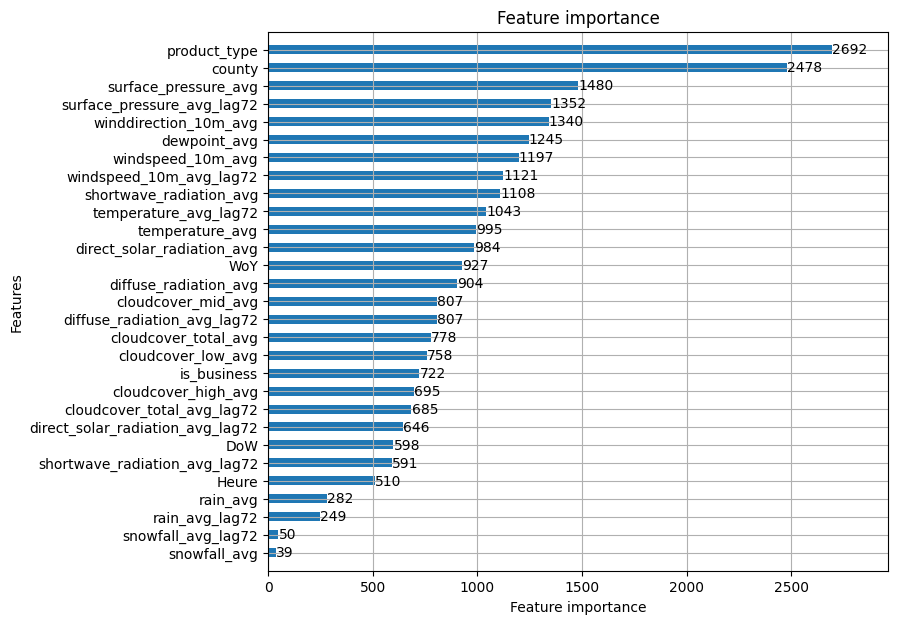

In [19]:
# Assuming your trained model is stored in the variable `model`
lgb.plot_importance(clf, height=0.5, figsize=(8,7))
plt.show()

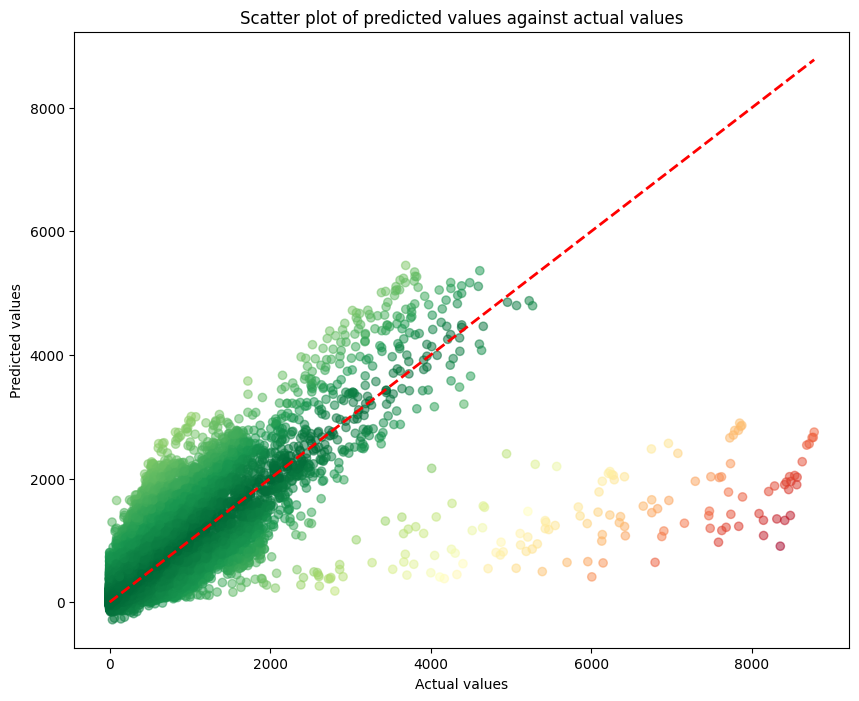

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
c = abs(y_test - y_pred) / (y_test.max() - y_test.min())
plt.scatter(y_test, y_pred, alpha=0.5, c=c, cmap='RdYlGn_r')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter plot of predicted values against actual values")
plt.show()

Despite a theoritical good MAE <i>(remember : here the test set is the last 20% of the train set, not the provided test set that goes from 28/05 to 01/06/23)</i>, <br>we can see from the last plot that the model cannot capture and predict extreme values.
<br>
<br>
But as specified at the beginning : the primary goal was to identify to the contributing features to an LGBM model, pulling apart lags, and trend + seasonal forecast that we will do in a separate model, and ensemble 'residuals' with another LGBM model like this one.